<a href="https://colab.research.google.com/github/lukeolson/imperial-multigrid/blob/master/lecture-3-amg-basics/14-anisotropy-cf-amg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# you may need to install pyamg
!pip install pyamg

In [1]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

%matplotlib inline

import pyamg

###  Anisotropy

For this example, let's try a fairly small grid.

And test $\varepsilon = 0.01$ with a rotation of $\theta = \frac{\pi}{2}$ and $\theta=\frac{\pi}{4}$.

In [6]:
#theta = np.pi / 2
theta = np.pi / 4
epsilon = 0.01
nx = 20
ny = nx
stencil = pyamg.gallery.diffusion.diffusion_stencil_2d(type='FD', epsilon=epsilon, theta=theta)
print(stencil)
A = pyamg.gallery.stencil_grid(stencil, (nx, ny), format='csr')

[[-0.2475 -0.505   0.2475]
 [-0.505   2.02   -0.505 ]
 [ 0.2475 -0.505  -0.2475]]


###  Build a CF hierarchy

Use `ruge_stuben_solver` to build a CF hierarchy. With a few notes:

- `keep` will simply retain all of the "extra" operators used to build the hierarch.  For example a list of the C/F nodes on each level.
- `strength` sets the strength parameters.  Here `classical` is normally used.  The `norm` equal to `min` (rather than `abs`) avoids using the absolute value in the strength test so that large positive entries are treated as weak connections.

In [7]:
ml = pyamg.ruge_stuben_solver(A, keep=True,
                              strength=('classical',
                                        {'theta': 0.25,
                                         'norm': 'min'}))
print(ml)

multilevel_solver
Number of Levels:     5
Operator Complexity:  1.914
Grid Complexity:      1.548
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0          400         3364 [52.24%]
    1          133         1689 [26.23%]
    2           66         1226 [19.04%]
    3           16          146 [ 2.27%]
    4            4           14 [ 0.22%]



### View the splitting

We can vew the C/F splitting by inspecting the first `level`.

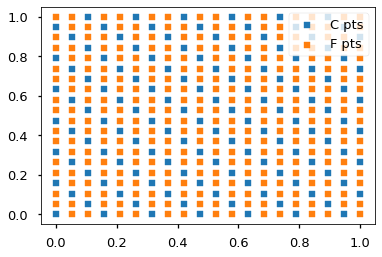

In [8]:
X, Y = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,ny))
X = X.ravel()
Y = Y.ravel()

# The CF splitting, 1 == C-node and 0 == F-node
splitting = ml.levels[0].splitting
C_nodes = splitting == 1
F_nodes = splitting == 0

plt.scatter(X[C_nodes], Y[C_nodes],
            marker='s',
            s=30.0, label='C pts')
plt.scatter(X[F_nodes], Y[F_nodes],
            marker='s',
            s=30.0, label='F pts')
plt.legend()

### The `ml` hierarchy

Notice a few things about the hierarchy...

Each level has a number of attributes/functions:
- `A` is the operator on this level
- `P` interpolates **to** this level
- `R` restricts **from** this level.  Simply `R=P.T` in this case.
- `C` is a sparse matrix of strong connections
- `splitting` holds C/F information
- `presmoother` and `postsmoother` point to the relaxation routine

In [9]:
dir(ml.levels[0])

['A',
 'C',
 'P',
 'R',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'postsmoother',
 'presmoother',
 'splitting']

- `Operator complexity` is the total sum of the `nnz` in all operators `A` compared to the fine level

In [10]:
Asizes = [ml.levels[i].A.nnz for i in range(len(ml.levels))]
print(Asizes)
print(np.sum(Asizes)/Asizes[0])

[3364, 1689, 1226, 146, 14]
1.914090368608799


- `Grid Complexity` is the total sum of the unknowns per level, compared to the fine level

In [11]:
Asizes = [ml.levels[i].A.shape[0] for i in range(len(ml.levels))]
print(Asizes)
print(np.sum(Asizes)/Asizes[0])

[400, 133, 66, 16, 4]
1.5475


### Set up a problem and solve

Now, set $f=0$ and the initial $u$ to random and solve.

Note: you can set `accel='cg'` to use AMG as a preconditioner

In [12]:
f = np.zeros(A.shape[0])
u0 = np.random.randn(A.shape[0])
res = []
u = ml.solve(b=f, x0=u0, residuals=res)

In [13]:
res = np.array(res)
res[1:] / res[:-1]

array([0.01719434, 0.07204551, 0.12220994, 0.17406996, 0.20569354,
       0.22239996, 0.23321024, 0.24117889])

### Make a bigger problem!

In [14]:
theta = np.pi / 4
epsilon = 0.01
nx = 1000
ny = nx
stencil = pyamg.gallery.diffusion.diffusion_stencil_2d(type='FD', epsilon=epsilon, theta=theta)
print(stencil)
A = pyamg.gallery.stencil_grid(stencil, (nx, ny), format='csr')

[[-0.2475 -0.505   0.2475]
 [-0.505   2.02   -0.505 ]
 [ 0.2475 -0.505  -0.2475]]


In [15]:
ml = pyamg.ruge_stuben_solver(A, keep=True,
                              strength=('classical',
                                        {'theta': 0.25,
                                         'norm': 'min'}))
print(ml)

multilevel_solver
Number of Levels:     10
Operator Complexity:  2.260
Grid Complexity:      1.569
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0      1000000      8988004 [44.24%]
    1       333333      4984009 [24.53%]
    2       166666      4468716 [22.00%]
    3        41666       863038 [ 4.25%]
    4        20665       821995 [ 4.05%]
    5         5165       151083 [ 0.74%]
    6         1302        28590 [ 0.14%]
    7          346         6758 [ 0.03%]
    8          156         4178 [ 0.02%]
    9           32          294 [ 0.00%]



In [19]:
f = np.zeros(A.shape[0])
u0 = np.random.randn(A.shape[0])
res = []
u = ml.solve(b=f, x0=u0, residuals=res, accel='cg')

In [20]:
res = np.array(res)
res[1:] / res[:-1]

array([0.02440939, 0.08483446, 0.13912844, 0.16838448, 0.16485517])

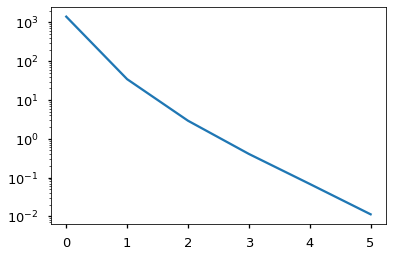

In [21]:
plt.semilogy(res)